In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def ranking_analyzer_vector_output(output,names):
    # importing necessary libraries
    from itertools import combinations
    # getting vectors from the data frame
    perc1 = np.array(output[names[0]])
    perc2 = np.array(output[names[1]])
    percscore = np.array(output['score'])
    # getting the combinations
    combs = list(combinations(np.arange(32), 2))
    ncombs = len(combs)
    # initiailizing the vectors
    scorediff = np.zeros(int(ncombs))
    wins1diff = np.zeros(int(ncombs))
    wins2diff = np.zeros(int(ncombs))
    # Computing the values
    for counter, pairs in enumerate(combs):
        scorediff[counter] = percscore[pairs[0]] - percscore[pairs[1]]
        wins1diff[counter] = perc1[pairs[0]] - perc1[pairs[1]]
        wins2diff[counter] = perc2[pairs[0]] - perc2[pairs[1]] 
    
    return scorediff, wins1diff,wins2diff

In [3]:
def ranking_plotter(scorediff,wins1diff,wins2diff, alpha,threshold = 0):
    # putting in a mask for plotting perspective

    threshmask = scorediff > threshold
    scoreplt = scorediff[threshmask]
    winsplt = wins2diff[threshmask]
    winsold = wins1diff[threshmask]
        
    correctmask = winsplt > 0
    xc = scoreplt[correctmask]
    yc = winsplt[correctmask]
    xic = scoreplt[np.invert(correctmask)]
    yic = winsplt[np.invert(correctmask)]
    
    doublecorrectmask = np.logical_and(winsplt>0,winsold<0)
    xcstar = scoreplt[doublecorrectmask]
    ycstar = winsplt[doublecorrectmask]
    
    doubleincorrectmask = np.logical_and(winsplt<0,winsold<0)
    xicstar = scoreplt[doubleincorrectmask]
    yicstar = winsplt[doubleincorrectmask]
    
    plt.figure(figsize=(15,7))
    plt.plot(scorediff,wins2diff,'ko',label = "Predictions Outside of Threshold",color = "dimgray")
    plt.plot(xc,yc,'bo',label = "Both Models Predicted the Same",color = "lightgray")
    plt.plot(xic,yic,'bo',color = "lightgray")
    plt.plot(xcstar,ycstar,'go',label = "PageRank Alone Correct",markersize = 7,color = "limegreen")
    plt.plot(xicstar,yicstar,'ro',label = "Wins Alone Correct",markersize = 7)
    plt.plot([0,1.01*np.max(scorediff)],[0,0],'k-',linewidth = 3)
    plt.plot([threshold,threshold],[np.min(wins2diff),np.max(wins2diff)],'k-',linewidth = 3)
    plt.xlabel('Difference in PageRank Score')
    plt.ylabel('Difference in Following Year Winning Percentage')
    plt.legend()
    plt.grid()
        
    
    # Getting the percentage of games where a team with a same or worse record in year N
    # with a better PageRank ended up being better in year N+1
    # Threshold determines amount PageRank needs to be better by
    
    
    # Getting the total combinations right
    perc_correct_score = sum(winsplt>0)/len(scoreplt)
    perc_correct_wins = (sum(np.logical_and(winsold>0,winsplt>0))+ \
                         sum(np.logical_and(winsold<0,winsplt<0)))/len(winsplt)
    
    plt.title(r'PageRank Perc Correct: %.3f, Wins Perc Correct: %.3f, $\alpha$ = %.2f' %(perc_correct_score,perc_correct_wins,alpha))
    
    return perc_correct_score,perc_correct_wins
    

In [4]:
# method
alphas = np.linspace(.025,.95,30)
filesScore = ["Pij_2009.csv","Pij_2010.csv",
              "Pij_2011.csv","Pij_2012.csv",
              "Pij_2013.csv","Pij_2014.csv",
              "Pij_2015.csv","Pij_2016.csv",
              "Pij_2017.csv","Pij_2018.csv"]

filesPercs = ["2009_win_perc.csv","2010_win_perc.csv","2011_win_perc.csv","2012_win_perc.csv",
             "2013_win_perc.csv","2014_win_perc.csv","2015_win_perc.csv",
             "2016_win_perc.csv","2017_win_perc.csv","2018_win_perc.csv"]
namesCols = ["win_perc_2009","win_perc_2010","win_perc_2011","win_perc_2012",
            "win_perc_2013","win_perc_2014","win_perc_2015",
            "win_perc_2016","win_perc_2017","win_perc_2018"]

In [5]:
def contrary_plot(threshold, alpha, method,filesScore,filesPercs,namesCols, nSims = 10000,weighted = True):
        
    # initializing the scorediff, wins1diff, and wins2diff vectors
    scorediff_vect = np.array([])
    wins1diff_vect = np.array([])
    wins2diff_vect = np.array([])
    
    
    for year_of_data in np.arange(len(filesScore) - 1):
            
        # reading in the data
        data = pd.read_csv(filesScore[year_of_data],index_col=0)
        stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
        stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
        # converting to a numpy array
        data2 = np.array(data)
            
        if(weighted == False):
                data2[data2!=0] = 1
            
        # making the Pij matrix
        Pij = data2/data2.sum(axis=0)
            
        # If we want the teleportation probabilties unifrom,
        # or based on team winning perc
        if method == 0:
            # making the teleporting probabilities uniform
            v = np.ones(32)/32
            v = v[np.newaxis]
            v = v.T
            # Setting eT
            eT = np.ones(32)[np.newaxis]   
        else:
            # making the teleporting probabilities proportional to
            # the teams winning percentages
            v = np.array(stats1[namesCols[year_of_data]])
            v = v[np.newaxis]
            v = v.T
            v = v/np.sum(v)
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(32)[np.newaxis]
                
        # initializing our first guess
        x0 = np.ones(32)/32
        x0 = x0[np.newaxis]
        x0 = x0.T
            
        # performing the simulation
        for i in range(nSims):
            x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v

        # defining the team names
        team_names = np.array(data.columns.get_values())
            
        # ordering the team's by their score
        mask = np.argsort(np.squeeze(x0))[::-1]
        x0_df = np.squeeze(x0[mask])
        team_names_df = team_names[mask]
            
        # forming a data frame
        teamrank = {'Team': team_names_df, 'score': x0_df, 'wins': 32*16/2*x0_df}
        teamrank_df = pd.DataFrame(data=teamrank)
            
        output = pd.merge(teamrank_df,
                stats1,
                left_on = "Team",
                right_on = "team",
                how = "inner")

        output = pd.merge(output,
                stats2,
                left_on = "Team",
                right_on = "team",
                how = "inner")
        
        names = [namesCols[year_of_data],namesCols[year_of_data+1]]
        scorediff, wins1diff,wins2diff = ranking_analyzer_vector_output(output,names)
        
        scorediff_vect = np.append(scorediff_vect,scorediff)
        wins1diff_vect = np.append(wins1diff_vect,wins1diff)
        wins2diff_vect = np.append(wins2diff_vect,wins2diff)
    
    perc_correct_score,perc_correct_wins = \
    ranking_plotter(scorediff_vect,wins1diff_vect,wins2diff_vect, alpha,threshold)

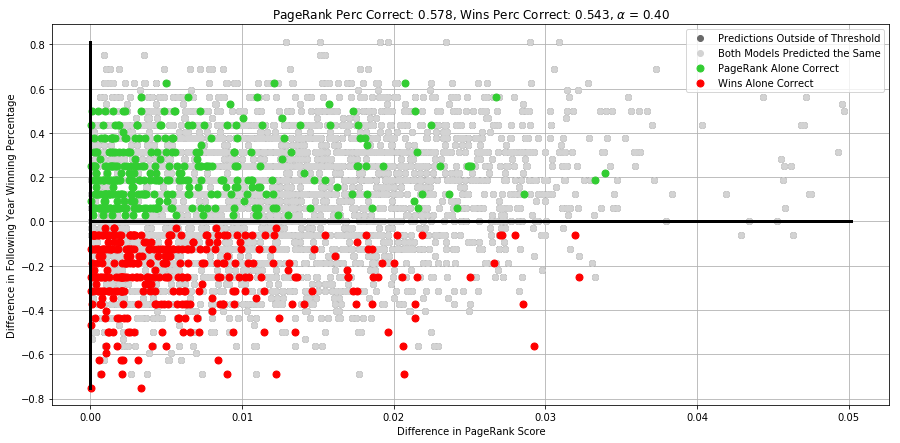

In [6]:
contrary_plot(0, 0.4, 0,filesScore,filesPercs,namesCols)

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [9]:
interact(contrary_plot,threshold =(0.0,.03,0.0025)\
         ,alpha = (0.05,.9,.05),method = [('Uniform Nu', 0), ('Proportional Nu', .02)]\
         ,filesScore = fixed(filesScore) ,filesPercs = fixed(filesPercs),namesCols = fixed(namesCols)\
        ,nSims = fixed(5000));

A Jupyter Widget